In [30]:
import pandas as pd
import plotly.graph_objects as go
import torch

from darts.dataprocessing.transformers import Scaler

In [31]:
df = pd.read_excel('dataset/kawaldata_clean.xlsx', parse_dates=True)
df.head()

,Unnamed: 0,tanggal,Kasus harian,Total kasus,Kasus aktif,Sembuh\n(baru),Sembuh,Meninggal\n(baru),Meninggal\nDunia,Tingkat kematian (seluruh kasus),...,Unnamed: 41,Dosis pertama,Dosis kedua,Dosis ketiga,Dosis pertama (%),Dosis kedua (%),Dosis pertama (harian),Dosis kedua (harian),Dosis harian,Dosis pertama (mingguan)
0,0,2020-03-02,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-03-03,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020-03-04,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2020-03-05,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2020-03-06,2.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **COVID-19 Indonesia Statistics**

In [32]:
df_stats = pd.concat([df['tanggal'], df['Kasus harian'], df['Meninggal\n(baru)'], df['Sembuh\n(baru)']], axis=1)
df_stats = df_stats.loc[(df.tanggal >= "2021-01-13")]
df_stats = df_stats.dropna()

print(f'Total Statistic Days {len(df_stats)}')

Total Statistic Days 219


In [33]:
line_stat = []
line_stat.append(go.Scatter(x=df_stats.tanggal, y=df_stats['Kasus harian'], name="Kasus Harian", mode='lines'))
line_stat.append(go.Scatter(x=df_stats.tanggal, y=df_stats['Sembuh\n(baru)'], name="Sembuh", mode='lines'))

fig = go.Figure(data=line_stat)
fig.update_layout(title_text="COVID-19 Case Indonesia")
fig.show()

## **Vaccination Indonesia Statistics**

In [34]:
df_vaccine = pd.concat([df['tanggal'], df['Dosis pertama (harian)'], df['Dosis kedua (harian)']], axis=1)
df_vaccine = df_vaccine.loc[(df.tanggal >= "2021-01-13")]

print(f'Total Vaccine Days {len(df_vaccine)}')


Total Vaccine Days 219


In [35]:
line_stat = []
line_stat.append(go.Scatter(x=df_vaccine.tanggal, y=df_vaccine['Dosis pertama (harian)'], name="Dosis Pertama", mode='lines'))
line_stat.append(go.Scatter(x=df_vaccine.tanggal, y=df_vaccine['Dosis kedua (harian)'], name="Dosis Kedua", mode='lines'))


fig = go.Figure(data=line_stat)
fig.update_layout(title_text="Vaccination Indonesia")
fig.show()

In [36]:
df_mobility = pd.read_csv("dataset/mobility_clean.csv")
df_mobility.tail()

,Unnamed: 0,index,date,retail_and_recreation_percent_change_from_baseline
211,544,2761772,2021-08-12,-11.0
212,545,2761773,2021-08-13,-14.0
213,546,2761774,2021-08-14,-16.0
214,547,2761775,2021-08-15,-17.0
215,548,2761776,2021-08-16,-8.0


In [37]:
len(df_mobility)

216

In [38]:
line_stat = []
line_stat.append(go.Scatter(x=df_mobility.date, y=df_mobility['retail_and_recreation_percent_change_from_baseline'], name="Retail And Recreation", mode='lines'))

fig = go.Figure(data=line_stat)
fig.update_layout(title_text="Indonesia Mobility")
fig.show()

In [39]:
df_bobot = pd.read_csv('dataset/bobot_2021.csv')
df_bobot = df_bobot.loc[(df_bobot.date >= "2021-01-13") & (df_bobot.date <= "2021-08-16")]
df_bobot.tail()


,Unnamed: 0,date,bobot
223,223,2021-08-12,0.4
224,224,2021-08-13,0.4
225,225,2021-08-14,0.7
226,226,2021-08-15,0.7
227,227,2021-08-16,0.7


In [40]:
len(df_bobot)

216

## **Time Series Feature Engineering**

- Drop Tanggal, Dosis kedua (harian) Column In df_vaccine
- Drop Meninggal Column In df_stats
- Filling NaN Value With 0
- Seperating Train Variable With Date

In [41]:
df_vaccine = df_vaccine.drop(columns=['tanggal', 'Dosis kedua (harian)'], axis=1)
df_mobility = df_mobility.drop(columns=['date', 'Unnamed: 0', 'index'], axis=1)
df_stats = df_stats.drop(columns=['Meninggal\n(baru)'], axis=1)
df_bobot = df_bobot.drop(columns=['Unnamed: 0', 'date'])

In [42]:
df_timeseries = pd.concat([
       df_vaccine.reset_index(drop=True), 
       df_stats.reset_index(drop=True),
       df_mobility.reset_index(drop=True),
       df_bobot.reset_index(drop=True)
], axis=1)

df_timeseries = df_timeseries.dropna()


In [43]:
variable = df_timeseries.loc[:, df_timeseries.columns != 'tanggal']
variable = list(variable)
variable

['Dosis pertama (harian)',
 'Kasus harian',
 'Sembuh\n(baru)',
 'retail_and_recreation_percent_change_from_baseline',
 'bobot']

## **Time Series Modelling**

In [44]:
from darts import TimeSeries

scaler = Scaler()
series = scaler.fit_transform(TimeSeries.from_dataframe(df_timeseries, 'tanggal', variable))

train, val = series.split_after(pd.Timestamp("2021-07-01"))
# series = scaler.fit_transform(train)
train = series
val = scaler.fit_transform(val)


In [45]:
from darts.models import NBEATSModel

model = NBEATSModel(
    input_chunk_length=15,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=12,
    num_blocks=6,
    num_layers=6,
    layer_widths=512,
    n_epochs=200,
    batch_size=600,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model.fit(train, val_series=val, verbose=True)


[2021-08-21 14:36:09,199] INFO | darts.models.torch_forecasting_model | Train dataset contains 195 samples.
[2021-08-21 14:36:09,199] INFO | darts.models.torch_forecasting_model | Train dataset contains 195 samples.


cuda:0


  0%|          | 0/200 [00:00<?, ?it/s]

## **Historical Prediction - Last Month** 

In [54]:
pred_series = model.historical_forecasts(
    train,
    start=pd.Timestamp("2021-03-20"),
    retrain=False,
    verbose=True
)

  0%|          | 0/150 [00:00<?, ?it/s]

R2 Score: 0.8883065728754346


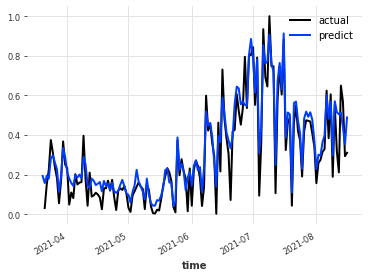

In [55]:
from darts.metrics import r2_score
ts_transformed = train.drop_before(pd.Timestamp("2021-03-20"))

ts_transformed['0'].univariate_component(0).plot(label='actual')
pred_series['0'].plot(label='predict')

print('R2 Score:', r2_score(ts_transformed.univariate_component(0), pred_series['0']))

## **Future Prediction**

In [48]:
prediction = model.predict(500)
prediction = prediction.pd_dataframe()

In [49]:
series = series.pd_dataframe()

In [50]:
from datetime import date

min_case = prediction[['0']].idxmin()
min_case = date(2021, 8, 17) - min_case[0].date()
min_case = abs(min_case.days)

dates = list(pd.date_range(start="2021-08-20", periods=min_case))

In [60]:
min_case = date(2021, 8, 17) - date(2021, 11, 8)
min_case = abs(min_case.days)
dates = list(pd.date_range(start="2021-08-17", periods=min_case))

In [61]:
prediction = prediction.reset_index()
series = series.reset_index()

for i, col in enumerate(variable):
    prediction = prediction.rename(columns={'{}'.format(i) : col})
    series = series.rename(columns={'{}'.format(i): col})

In [62]:
line_stat = []

for x in range(0,2):
    line_stat.append(go.Scatter(x=df_timeseries.tanggal, y=series[variable[x]], name=variable[x], mode='lines'))
    line_stat.append(go.Scatter(x=dates, y=prediction[variable[x]], name=f'Forecast {variable[x]}', mode='lines'))

fig = go.Figure(data=line_stat)
fig.update_layout(title_text=f"Predict COVID-19 Indonesia Within {min_case} Days Periods")
fig.show()